# Look at Elvington, train on 70% and test on 30%

In [2]:
# pip install openpyxl

In [5]:
import dimension
import glob
import pandas as pd
import pathlib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from collections import OrderedDict
from sklearn.metrics import accuracy_score
import re
import string
from sklearn.metrics import roc_curve
from numpy import argmax
from sklearn.metrics import roc_auc_score

# Functions

In [6]:
def clean_text(text):
    """
    Takes text and cleans
    
    :param str text: Text
    :return: Cleaned text
    """
    # text_nonum = re.sub(r'\d+', '', text)  # remove numbers
    text_nonum = " ".join(s for s in text.split() if not any(c.isdigit() for c in s))  # remove words with any digits
    text_split_upper = re.sub(r'((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))', r' \1', text_nonum)  # use regex to separate words with spaces then split
    text_nopunct = "".join([char.lower() for char in text_split_upper if char not in string.punctuation])  # remove punctuation and convert character to lower case
    text_no_doublespace = re.sub("\s+", " ", text_nopunct).strip()  # substitue multiple whitespace for single. Remove leading and trailing whitespace
    text_no_single = " ".join([w for w in text_no_doublespace.split() if len(w)>2])
    return text_no_single


def preprocess(label_df, scada_df):
    """
    Preprocesses data ready for vectorization
    
    :param label_df: Labelled dataframe
    :param scada_df: Dataframe from scada
    :return: Processed dataframe
    """
    # Prepare dictionary matching description and egu to tag
    desc_dict = scada_df.set_index('TAG').to_dict()['DESCRIPTION']
    egu_dict = scada_df.set_index('TAG').to_dict()['EGU TAG']

    target_labels = ['tag_category', 'tag_subcategory', 'functional_area', 'process_area']

    df = label_df.copy()
    df['description'] = df['scada_tag'].apply(lambda x: desc_dict.get(x))  # map description
    df['egu'] = df['scada_tag'].apply(lambda x: egu_dict.get(x))  # map egu

    # clean features
    df.loc[:, ['sc_tag']] = df['scada_tag'].str.replace('_', ' ')
    df.loc[:, ['sc_tag']] = df['sc_tag'].fillna(' ')
    df.loc[:, ['desc']] = df['description'].str.replace("_", " ")
    df.loc[:, ['desc']] = df['desc'].fillna(' ')
    df.loc[:, ['egu']] = df['egu'].fillna(' ')

    # clean labels
    for label in target_labels:
        df.loc[:, [label]] = df[label].str.strip().replace(" ", "").str.title()

    # combine description features
    df.loc[:, ['clean_desc']] = df['sc_tag'] + ' ' + df['desc'] + ' ' + df['egu'].astype(str)
    df.loc[:, ['clean_desc']] = df['clean_desc'].str.strip()
    df = df[['scada_tag', 'description', 'egu', 'clean_desc', 'site_name', 'tag_category', 'tag_subcategory', 'functional_area', 'process_area']]

    # Fix label inconsistencies between sites
    df = df.replace({'1-Raw Water': '1-Raw Water Intake'})
    df = df.replace({'Rapid Gravity Filters': 'Rapid Gravity Filtration'})

    df['clean_desc'] = df['clean_desc'].str.replace("RGF", " RGF ")
    df['clean_desc'] = df['clean_desc'].str.replace("GAC", " GAC ")
    df['clean_desc'] = df['clean_desc'].apply(lambda x: clean_text(x))
    df['clean_desc'] = df['clean_desc'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')  # remove repeated
    
    ### these did not improve accuracy
    # df['clean_desc'] = df['clean_desc'].str.replace("rgf", "rapid gravity filter")
    # df['clean_desc'] = df['clean_desc'].str.replace("gac", "granular activated carbon")
    # df['clean_desc'] = df['clean_desc'].str.replace("daf", "dissolved air flotation")
    
    df = df[~df['site_name'].str.contains('0')]
    df = df.dropna(subset=target_labels)
    df = df.sort_values(by='site_name')
    df = df.reset_index(drop=True)
    return df


def run_vec(df):
    """
    Runs vectorization to generate word vectors
    
    :param df: Input dataframe
    :return: Dataframe with vector features concatanated
    """
    # no need to use idf since the text is already pretty sparse
    # sublinear tf scaling addresses the problem that 20 occurencs of a word is probably not 20 times more important than 1 occurence
    tfidf = TfidfVectorizer(use_idf=False)
    features = tfidf.fit_transform(df['clean_desc']).toarray()
    df = pd.concat([df, pd.DataFrame(features)], axis=1)
    return df
    

def generate_pred(X_train, y_train, X_test):
    """
    Generate predictions and probabilities using model
    
    :param X_train: Training features
    :param y_train: Training labels
    :param X_test: Testing features
    """
    model = RandomForestClassifier(n_estimators = 200, random_state=0)
    # svm = LinearSVC(random_state=0)
    # model = CalibratedClassifierCV(svm)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    return y_pred, y_proba


def generate_confusion(y_test, y_pred, annot_list, annot):
    """
    Generate confusion matrix and classification report
    
    :param y_test: Actual testing results
    :param y_pred: Predicted testing results
    :param annot_list: List of factorized target labels
    :param annot: True or false to show annotations on confusion matrix
    :return: Confusion matrix, classification report
    """
    conf_mat = confusion_matrix(y_test, y_pred)
    annotations = pd.DataFrame(conf_mat).astype(str).replace('0', '')

    fig, ax = plt.subplots(figsize=(15,12))
    if annot==True:
        sns.heatmap(conf_mat, annot=annotations, fmt='s', xticklabels=annot_list, yticklabels=annot_list)
    else:
        sns.heatmap(conf_mat, fmt='s')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Prediction of {target_label} - Accuracy={int(accuracy_score(y_test, y_pred)*100)}%. Test split={int(100*len(y_test)/(len(y_train)+len(y_test)))}%', fontweight='bold', pad=20)
    plt.show()
    print(metrics.classification_report(y_test, y_pred))
    
    
def mark_all_correct(df):
    """
    Makes a new column with 1 if all labels correct, 0 otherwise
    
    :param df: Result dataframe
    :return: New column with 1 if all correct
    """
    if (df['tag_category_correct']==1) and \
       (df['tag_subcategory_correct']==1) and \
       (df['functional_area_correct']==1) and \
       (df['process_area_correct']==1):
        return 1
    else:
        return 0


def choose_model(features, labels):
    """
    Input: TFIDF features, labels
    """
    models = [
        RandomForestClassifier(n_estimators= 200, random_state=0),
        LinearSVC(random_state=0),
        MultinomialNB(),
        LogisticRegression(random_state=0),
    ]

    # Cross validation
    CV=5
    metrics = ['accuracy', 'f1_weighted', 'f1_macro']
    for metric in metrics: 
        cv_df = pd.DataFrame(index=range(CV*len(models)))

        entries = []
        for model in models:
            model_name = model.__class__.__name__
            accuracies = cross_val_score(model, features, labels, scoring=metric, cv=CV)
            for fold_idx, accuracy in enumerate(accuracies):
                entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', metric])

        plt.figure(figsize=(8,6))
        sns.boxplot(x='model_name', y=metric, data=cv_df)
        sns.stripplot(x='model_name', y=metric, data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
        plt.title('Cross validation metric of different models')
        plt.show()
        print(cv_df.groupby('model_name')[metric].mean())
        print()

# Data ingestion

In [8]:
## Get Huby scada data
local_path = pathlib.Path(".").resolve()
huby_excel_file = list(local_path.glob("../data/YW_tags/WaterProd_HubyTags_Hal24KTrial_V3_AdamNLP.xlsx"))[0].resolve()
huby_scada_df = pd.read_excel(huby_excel_file, sheet_name="Huby-SCADATags", header=0, skiprows=[1], engine='openpyxl')

# Acomb scada data
acomb_excel_file = list(local_path.glob("../data/YW_tags/ACOMLDS1_CURRENT.xlsx"))[0].resolve()
acomb_scada_df = pd.read_excel(acomb_excel_file, sheet_name="ACOMLDS1_CURRENT", header=0, skiprows=[1], engine='openpyxl')

# Elvington scada data
elv_excel_file = list(local_path.glob("../data/YW_tags/ELVGTNS1_CURRENT.xlsx"))[0].resolve()
elv_scada_df = pd.read_excel(elv_excel_file, sheet_name="ELVGTNS1_CURRENT", header=0, skiprows=[1], engine='openpyxl')

# All 3 sites
all_scada_df = huby_scada_df[['TAG', 'DESCRIPTION']].append(acomb_scada_df[['TAG', 'DESCRIPTION']], ignore_index=True)
all_scada_df = all_scada_df.append(elv_scada_df[['TAG', 'DESCRIPTION', 'EGU TAG']], ignore_index=True)
all_scada_df = all_scada_df.reset_index(drop=True)

In [11]:
# Get labelled data

dim_sdk = dimension.Connect("../src/conf/mongo_conf.txt")
db = dim_sdk.db()
site_tags = db['site_tag_config']
cursor = site_tags.find({}, {"_id": 0,
                             "scada_tag": 1,
                             "site_name": 1,
                             "functional_area": 1, 
                             "process_area": 1, 
                             "tag_category": 1, 
                             "tag_subcategory": 1, 
                             "tag_name": 1,  
                             "common_reference": 1,
                             "is_alarm": 1
                             }
                         )
master_tag_data = list(cursor)
master_tag_dict = {tag_details.get("tag_name"): tag_details for tag_details in master_tag_data}
master_tag_df = pd.DataFrame(master_tag_data)
# site_tags.find_one()

# Labelled target data
huby_label_df = master_tag_df[master_tag_df['site_name']=='HUBY'].reset_index(drop=True)
acomb_label_df = master_tag_df[master_tag_df['site_name']=='ACOMB'].reset_index(drop=True)
elv_label_df = master_tag_df[master_tag_df['site_name']=='ELVINGTON'].reset_index(drop=True)
all_label_df = master_tag_df

Connecting to database.
Connection successful.


# Processing

In [12]:
df_all_proc = preprocess(all_label_df, all_scada_df)  # preprocess all data

df_a = df_all_proc[df_all_proc['site_name']=='ACOMB']
df_e = df_all_proc[df_all_proc['site_name']=='ELVINGTON']
df_h = df_all_proc[df_all_proc['site_name']=='HUBY']

df_a = df_a.reset_index(drop=True)
df_a = run_vec(df_a)  # vectorize text
df_e = df_e.reset_index(drop=True)
df_e = run_vec(df_e)  # vectorize text
df_h = df_h.reset_index(drop=True)
df_h = run_vec(df_h)  # vectorize text

df_a['tag_cat_id'] = df_a['tag_category'].factorize()[0]
df_a['tag_subcat_id'] = df_a['tag_subcategory'].factorize()[0]
df_a['func_area_id'] = df_a['functional_area'].factorize()[0]
df_a['proc_area_id'] = df_a['process_area'].factorize()[0]

df_e['tag_cat_id'] = df_e['tag_category'].factorize()[0]
df_e['tag_subcat_id'] = df_e['tag_subcategory'].factorize()[0]
df_e['func_area_id'] = df_e['functional_area'].factorize()[0]
df_e['proc_area_id'] = df_e['process_area'].factorize()[0]

df_h['tag_cat_id'] = df_h['tag_category'].factorize()[0]
df_h['tag_subcat_id'] = df_h['tag_subcategory'].factorize()[0]
df_h['func_area_id'] = df_h['functional_area'].factorize()[0]
df_h['proc_area_id'] = df_h['process_area'].factorize()[0]

feat_drop_cols = ['scada_tag','description','egu','clean_desc','site_name','tag_category','tag_subcategory', 'functional_area', 'process_area', 'tag_cat_id','tag_subcat_id','func_area_id','proc_area_id']

df_a_feat = df_a.drop(feat_drop_cols, axis=1)
df_e_feat = df_e.drop(feat_drop_cols, axis=1)
df_h_feat = df_h.drop(feat_drop_cols, axis=1)

df_a_lab_tag_cat = df_a['tag_cat_id']
df_a_lab_tag_subcat = df_a['tag_subcat_id']
df_a_lab_func_area = df_a['func_area_id']
df_a_lab_proc_area = df_a['proc_area_id']

df_e_lab_tag_cat = df_e['tag_cat_id']
df_e_lab_tag_subcat = df_e['tag_subcat_id']
df_e_lab_func_area = df_e['func_area_id']
df_e_lab_proc_area = df_e['proc_area_id']

df_h_lab_tag_cat = df_h['tag_cat_id']
df_h_lab_tag_subcat = df_h['tag_subcat_id']
df_h_lab_func_area = df_h['func_area_id']
df_h_lab_proc_area = df_h['proc_area_id']

# Model validation

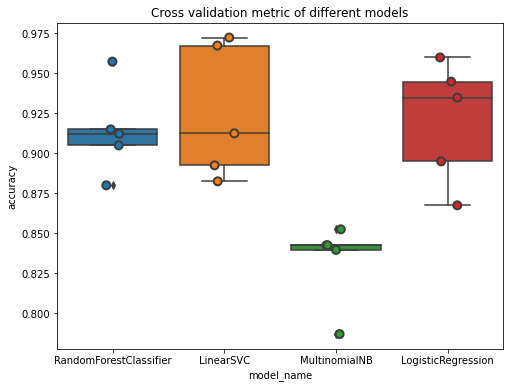

model_name
LinearSVC                 0.925470
LogisticRegression        0.920440
MultinomialNB             0.832813
RandomForestClassifier    0.913935
Name: accuracy, dtype: float64



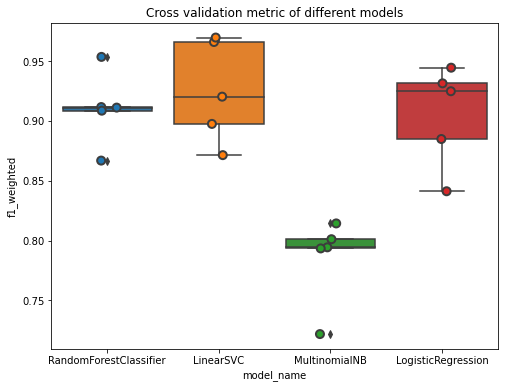

model_name
LinearSVC                 0.925005
LogisticRegression        0.905392
MultinomialNB             0.785002
RandomForestClassifier    0.910363
Name: f1_weighted, dtype: float64



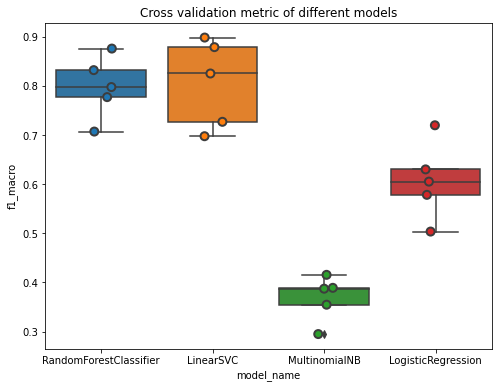

model_name
LinearSVC                 0.805607
LogisticRegression        0.607538
MultinomialNB             0.368354
RandomForestClassifier    0.798190
Name: f1_macro, dtype: float64



In [13]:
choose_model(df_e_feat, df_e_lab_tag_cat)

# Train test

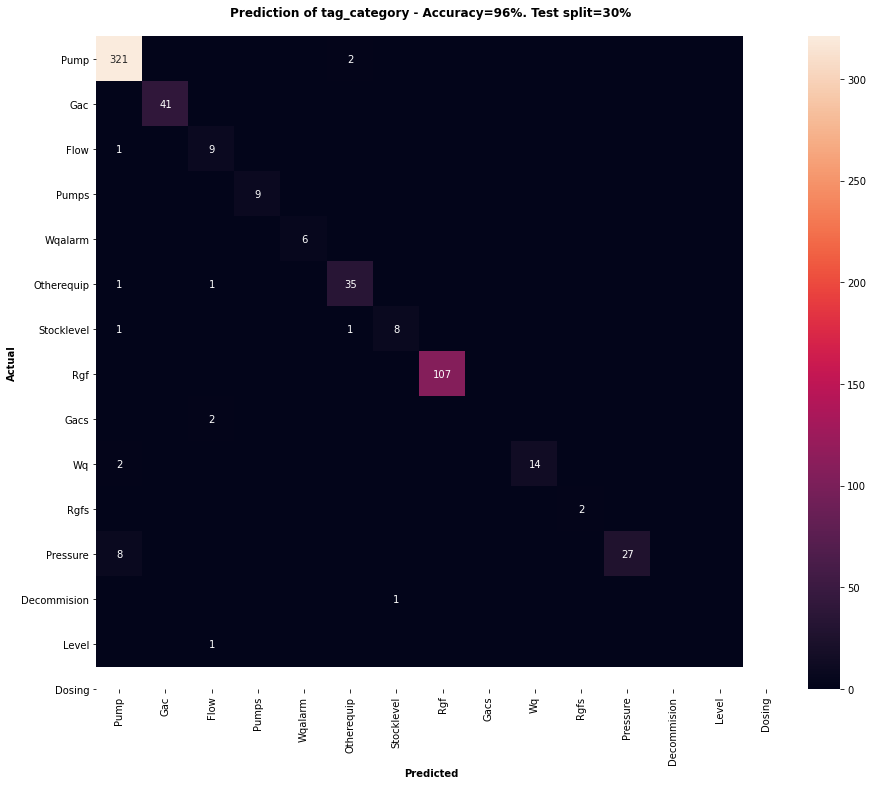

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       323
           1       1.00      1.00      1.00        41
           2       0.69      0.90      0.78        10
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.92      0.95      0.93        37
           6       0.89      0.80      0.84        10
           7       1.00      1.00      1.00       107
           8       0.00      0.00      0.00         2
           9       1.00      0.88      0.93        16
          10       1.00      1.00      1.00         2
          12       1.00      0.77      0.87        35
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1

    accuracy                           0.96       600
   macro avg       0.75      0.73      0.74       600
weighted avg       0.96      0.96      0.96       600



In [14]:
comb_df = pd.DataFrame()
target = df_e_lab_tag_cat
target_label = 'tag_category'
test_size=0.3

#### MODEL #####
X_train, X_test, y_train, y_test = train_test_split(df_e_feat, target, test_size=test_size, random_state=0)
y_pred, y_proba = generate_pred(X_train, y_train, X_test)
annot_list = df_e.loc[:, [target_label]].iloc[:,0].factorize()[1].tolist()
generate_confusion(y_test, y_pred, annot_list, True)

#### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res.columns=['y_test']
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

res['max_proba'] = res.iloc[:, 2:].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(pd.DataFrame(df_e.loc[:, [target_label]].iloc[:,0].factorize()[0]).drop_duplicates()[0], annot_list))  # dictionary of labels
res['actual'] = res['y_test'].map(tag_dict)
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

final_res = res[['actual', 'predicted', 'correct', 'max_proba']]
final_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']

###################

comb_df = pd.concat([comb_df, final_res], axis=1)

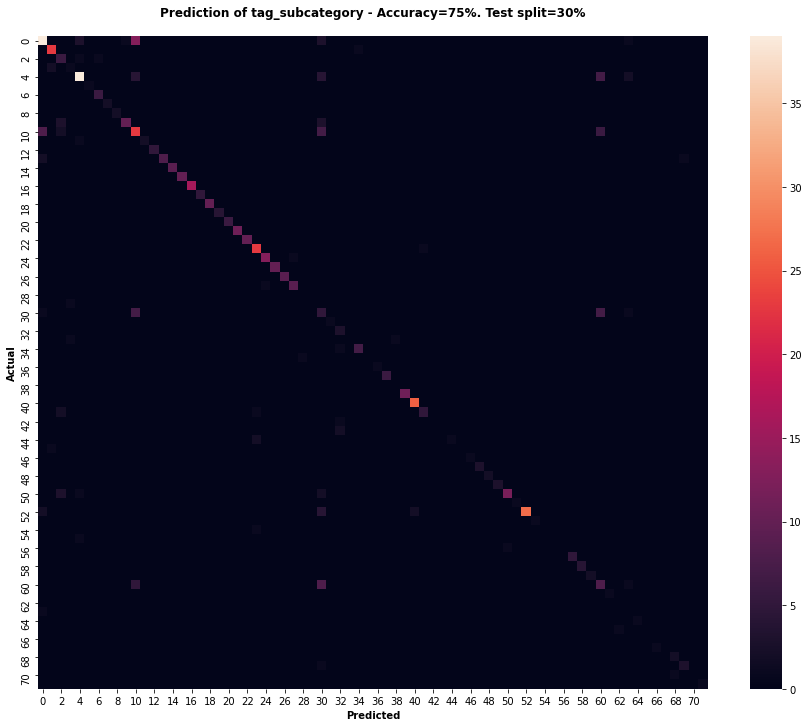

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        60
           1       0.88      0.96      0.92        24
           2       0.38      0.75      0.50         8
           3       0.33      0.33      0.33         3
           4       0.85      0.70      0.76        56
           5       1.00      1.00      1.00         1
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       0.91      0.62      0.74        16
          10       0.44      0.50      0.47        46
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         5
          13       1.00      0.73      0.84        11
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        16
          17       1.00    

In [15]:
target = df_e_lab_tag_subcat
target_label = 'tag_subcategory'

#### MODEL #####
X_train, X_test, y_train, y_test = train_test_split(df_e_feat, target, test_size=test_size, random_state=0)
y_pred, y_proba = generate_pred(X_train, y_train, X_test)
annot_list = df_e.loc[:, [target_label]].iloc[:,0].factorize()[1].tolist()
generate_confusion(y_test, y_pred, annot_list, False)

#### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res.columns=['y_test']
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

res['max_proba'] = res.iloc[:, 2:].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(pd.DataFrame(df_e.loc[:, [target_label]].iloc[:,0].factorize()[0]).drop_duplicates()[0], annot_list))  # dictionary of labels
res['actual'] = res['y_test'].map(tag_dict)
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

final_res = res[['actual', 'predicted', 'correct', 'max_proba']]
final_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']

###################

comb_df = pd.concat([comb_df, final_res], axis=1)

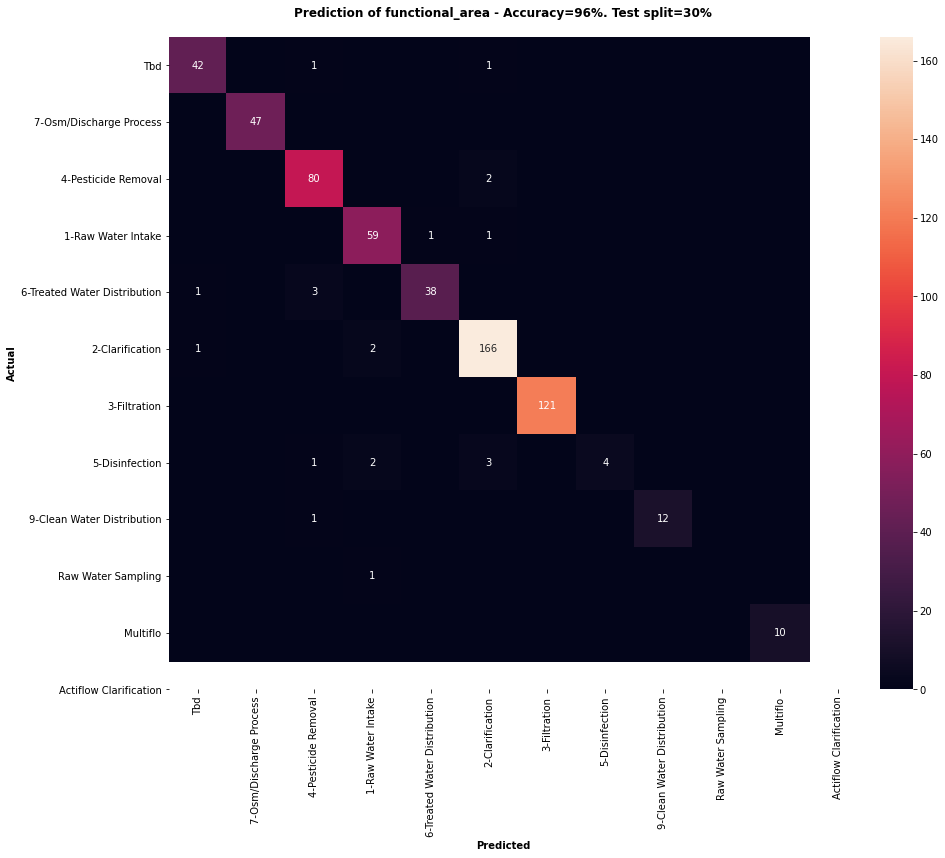

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       1.00      1.00      1.00        47
           2       0.93      0.98      0.95        82
           3       0.92      0.97      0.94        61
           4       0.97      0.90      0.94        42
           5       0.96      0.98      0.97       169
           6       1.00      1.00      1.00       121
           7       1.00      0.40      0.57        10
           8       1.00      0.92      0.96        13
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00        10

    accuracy                           0.96       600
   macro avg       0.89      0.83      0.84       600
weighted avg       0.96      0.96      0.96       600



In [16]:
target = df_e_lab_func_area
target_label = 'functional_area'

#### MODEL #####
X_train, X_test, y_train, y_test = train_test_split(df_e_feat, target, test_size=test_size, random_state=0)
y_pred, y_proba = generate_pred(X_train, y_train, X_test)
annot_list = df_e.loc[:, [target_label]].iloc[:,0].factorize()[1].tolist()
generate_confusion(y_test, y_pred, annot_list, True)

#### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res.columns=['y_test']
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

res['max_proba'] = res.iloc[:, 2:].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(pd.DataFrame(df_e.loc[:, [target_label]].iloc[:,0].factorize()[0]).drop_duplicates()[0], annot_list))  # dictionary of labels
res['actual'] = res['y_test'].map(tag_dict)
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

final_res = res[['actual', 'predicted', 'correct', 'max_proba']]
final_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']

###################

comb_df = pd.concat([comb_df, final_res], axis=1)

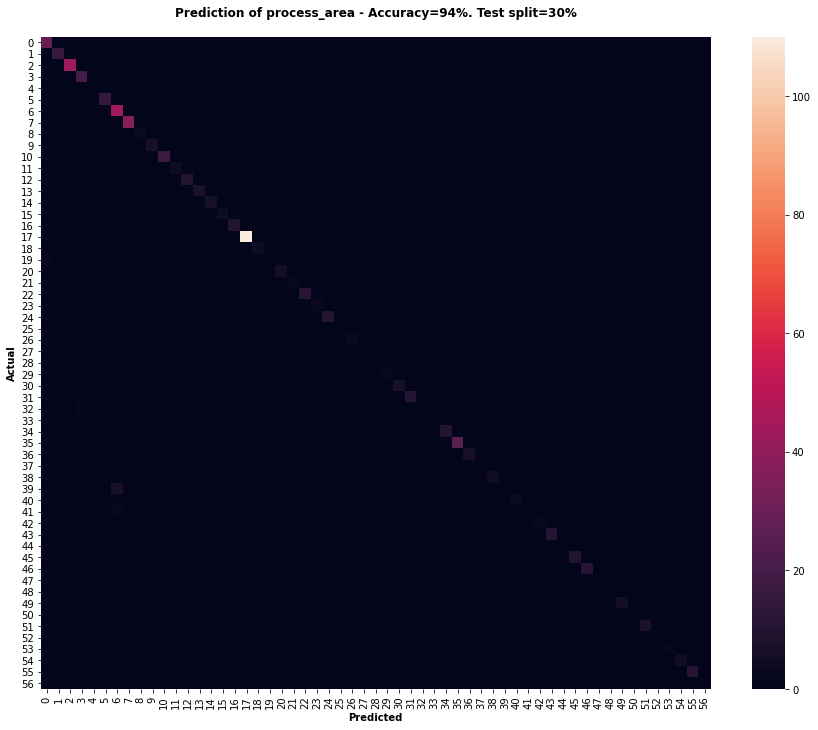

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       1.00      1.00      1.00        16
           2       0.96      1.00      0.98        43
           3       0.91      1.00      0.95        20
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00        16
           6       0.81      1.00      0.90        43
           7       0.95      1.00      0.97        37
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00        17
          11       0.80      0.80      0.80         5
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         4
          16       1.00      0.91      0.95        11
          17       0.99    

In [17]:
target = df_e_lab_proc_area
target_label = 'process_area'

#### MODEL #####
X_train, X_test, y_train, y_test = train_test_split(df_e_feat, target, test_size=test_size, random_state=0)
y_pred, y_proba = generate_pred(X_train, y_train, X_test)
annot_list = df_e.loc[:, [target_label]].iloc[:,0].factorize()[1].tolist()
generate_confusion(y_test, y_pred, annot_list, False)

#### RESULTS ANALYSIS #####
proba_df = pd.DataFrame(y_proba)
res = pd.DataFrame(y_test)
res.columns=['y_test']
res['copy_index']=res.index  # save index
res = res.reset_index(drop=True)  # reset index for merging
res = pd.concat([res, pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)  # merge predictions
res = pd.concat([res, proba_df], axis=1)  # merge probabilities
res = res.set_index('copy_index')  # re-instate index

res['max_proba'] = res.iloc[:, 2:].max(axis=1)  # add column with maximum probability

tag_dict = dict(zip(pd.DataFrame(df_e.loc[:, [target_label]].iloc[:,0].factorize()[0]).drop_duplicates()[0], annot_list))  # dictionary of labels
res['actual'] = res['y_test'].map(tag_dict)
res['predicted'] = res['y_pred'].map(tag_dict)
res['correct'] = np.where(res['actual'] == res['predicted'], 1, 0)  # add column checking if correct

final_res = res[['actual', 'predicted', 'correct', 'max_proba']]
final_res.columns = [f'{target_label}_actual', f'{target_label}_predicted', f'{target_label}_correct', f'{target_label}_max_proba']

###################

comb_df = pd.concat([comb_df, final_res], axis=1)

In [18]:
##### FINAL DATAFRAME PREPARATION #####
final_df = pd.DataFrame(columns=('scada_tag','description','egu', 'clean_desc'))
final_df = pd.concat([final_df, comb_df])

scada_dict = dict(zip(df_e.index, df_e['scada_tag']))
desc_dict = dict(zip(df_e.index, df_e['description']))
egu_dict = dict(zip(df_e.index, df_e['egu']))
clean_desc_dict = dict(zip(df_e.index, df_e['clean_desc']))

final_df['scada_tag'] = final_res.index.map(scada_dict)
final_df['description'] = final_res.index.map(desc_dict)
final_df['egu'] = final_res.index.map(egu_dict)
final_df['clean_desc'] = final_res.index.map(clean_desc_dict)

final_df['all_correct'] = final_df.apply(mark_all_correct, axis=1)
final_df['all_proba'] = final_df['tag_category_max_proba'] * final_df['tag_subcategory_max_proba'] * final_df['functional_area_max_proba'] * final_df['process_area_max_proba']

tag_cat_accuracy = int(100*final_df['tag_category_correct'].value_counts()[1] / len(final_df))
tag_subcat_accuracy = int(100*final_df['tag_subcategory_correct'].value_counts()[1] / len(final_df))
func_area_accuracy = int(100*final_df['functional_area_correct'].value_counts()[1] / len(final_df))
proc_area_accuracy = int(100*final_df['process_area_correct'].value_counts()[1] / len(final_df))
all_accuracy = int(100*final_df['all_correct'].value_counts()[1] / len(final_df))

print(f"Tag category accuracy: {tag_cat_accuracy}%")
print(f"Tag subcategory accuracy: {tag_subcat_accuracy}%")
print(f"Functional area accuracy: {func_area_accuracy}%")
print(f"Process area accuracy: {proc_area_accuracy}%")
print(f"Full row accuracy: {all_accuracy}%")

Tag category accuracy: 96%
Tag subcategory accuracy: 75%
Functional area accuracy: 96%
Process area accuracy: 94%
Full row accuracy: 72%


In [19]:
# final_df.to_csv(f'elv_test_size_{test_size}.csv')

# Probabilities

Text(0.5, 1.0, 'Tag category not correct (n=21)')

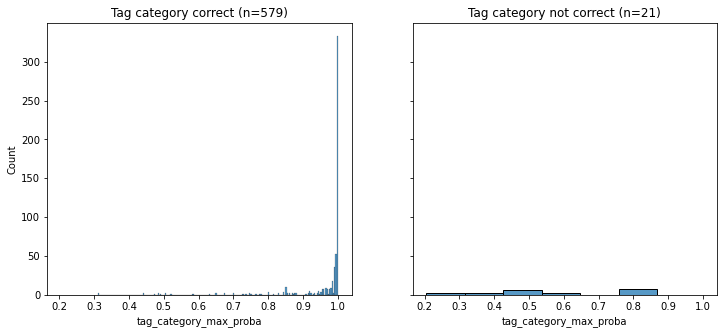

In [20]:
label='tag_category_correct'
proba='tag_category_max_proba'

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
sns.histplot(final_df[final_df[label]==1][proba], ax=axes[0])
sns.histplot(final_df[final_df[label]!=1][proba], ax=axes[1])

axes[0].set_title(f"Tag category correct (n={sum(final_df[label]==1)})")
axes[1].set_title(f"Tag category not correct (n={sum(final_df[label]!=1)})")

Text(0.5, 1.0, 'Not all correct (n=165)')

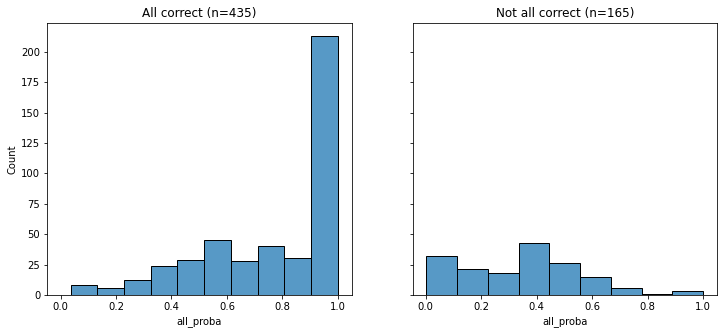

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
sns.histplot(final_df[final_df['all_correct']==1]['all_proba'], ax=axes[0])
sns.histplot(final_df[final_df['all_correct']!=1]['all_proba'], ax=axes[1])

axes[0].set_title(f"All correct (n={sum(final_df['all_correct']==1)})")
axes[1].set_title(f"Not all correct (n={sum(final_df['all_correct']!=1)})")